In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import *
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from math import *
#import pandas as pd

from scipy import interpolate
from scipy.optimize import curve_fit 

from astropy.io import fits
from astropy.table import Table
from astropy.table import vstack
from astropy.coordinates import SkyCoord, ICRS, Galactic
# import astropy.units as u
import astropy.units as units
import astropy.coordinates as coord
#from matplotlib.colors import LogNorm

# from mpl_toolkits.axes_grid1 import make_axes_locatable
# #import matplotlib.ticker as mtick


import os
#%matplotlib widget
import seaborn as sns
import os, sys


# from astropy.io import ascii
# from astropy.coordinates import galactocentric_frame_defaults

import sklearn
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier

from scipy import interpolate

import random
from scipy import integrate


gcolor = ['c','blue','g','r','orange', 'green','cyan']

In [2]:
import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
import sys,glob
from pathlib import Path

from ppxf.ppxf import ppxf, robust_sigma

from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins

In [3]:
c = 299792.458  # spped of light [km/s]

In [4]:
# input info
galaxy_name = 'VCC_308'
spectrum_filename = 'VCC0308_stack.fits'
spectrum_z = 0.0055

In [5]:
## Code from example

class read_data_cube:
    def __init__(self, filename, lam_range, redshift):
        """Read data cube, de-redshift, log rebin and compute coordinates of each spaxel."""

        self.read_fits_file(filename)

        # Only use the specified rest-frame wavelength range
        wave = self.wave/(1 + redshift)      # de-redshift the spectrum
        w = (wave > lam_range[0]) & (wave < lam_range[1])
        wave = wave[w]
        cube = self.cube[w, ...]
        cubevar = self.cubevar[w, ...]

        signal = np.nanmedian(cube, 0)
        noise = np.sqrt(np.nanmedian(cubevar, 0))

        # Create coordinates centred on the brightest spaxel
        jm = np.argmax(signal)
        row, col = map(np.ravel, np.indices(cube.shape[-2:]))
        x = (col - col[jm])*self.pixsize_x
        y = (row - row[jm])*self.pixsize_y

        # Transform cube into 2-dim array of spectra
        npix = cube.shape[0]
        spectra = cube.reshape(npix, -1)        # create array of spectra [npix, nx*ny]
        variance = cubevar.reshape(npix, -1)    # create array of variance [npix, nx*ny]

        c = 299792.458  # speed of light in km/s
        velscale = np.min(c*np.diff(np.log(wave)))  # Preserve smallest velocity step
        lam_range_temp = [np.min(wave), np.max(wave)]
        spectra, ln_lam_gal, velscale = util.log_rebin(lam_range_temp, spectra, velscale=velscale)

        # Coordinates and spectra only for spaxels with enough signal
        self.spectra = spectra
        self.variance = variance
        self.x = x
        self.y = y
        self.signal = signal.ravel()
        self.noise = noise.ravel()

        self.col = col + 1   # start counting from 1
        self.row = row + 1
        self.velscale = velscale
        self.ln_lam_gal = ln_lam_gal
        self.fwhm_gal = self.fwhm_gal/(1 + redshift)  

###############################################################################

    def read_fits_file(self, filename):
        """
        Read MUSE cube, noise, wavelength, spectral FWHM and pixel size.

        It must return the cube and cuberr as (npix, nx, ny) and wave as (npix,)

        IMPORTANT: This is not a general function! Its details depend on the
        way the data were stored in the FITS file and the available keywords in
        the FITS header. One may have to adapt the function to properly read
        the FITS file under analysis.                
        """
        hdu = fits.open(filename)
        head = hdu[0].header
        cube = hdu[0].data * (10 ** 18)
        cubevar = np.empty_like(cube)  # This file contains no errors

        # Only use the specified rest-frame wavelength range
        wave = head['CRVAL3'] + head['CD3_3']*np.arange(cube.shape[0])

        self.cube = cube
        self.cubevar = cubevar
        self.wave = wave
        # self.fwhm_gal = 2.62  # Median FWHM = 2.62Å. Range: 2.51--2.88 (ESO instrument manual). 
        self.fwhm_gal = 1
        # self.pixsize = abs(head["CDELT1"])*3600    # 0.2"
        self.pixsize_x = abs(np.sqrt((head['CD1_1'])**2+(head['CD2_1'])**2))*3600
        self.pixsize_y = abs(np.sqrt((head['CD1_2'])**2+(head['CD2_2'])**2))*3600


## Function to iteratively clip the outliers

In [6]:
## Code from example

def clip_outliers(galaxy, bestfit, mask):
    """
    Repeat the fit after clipping bins deviants more than 3*sigma in relative
    error until the bad bins don't change any more. This function uses eq.(34)
    of Cappellari (2023) https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C
    """
    while True:
        scale = galaxy[mask] @ bestfit[mask]/np.sum(bestfit[mask]**2)
        resid = scale*bestfit[mask] - galaxy[mask]
        err = robust_sigma(resid, zero=1)
        ok_old = mask
        mask = np.abs(bestfit - galaxy) < 3*err
        if np.array_equal(mask, ok_old):
            break
            
    return mask

## Function to fit the stellar kinematics
The following function fits the spectrum with `pPXF` while masking the gas
emission lines, then iteratively clips the outliers and finally refit the
spectrum with `pPXF` on the cleaned spectrum.

In [7]:
## Code from example

def ppxf_fit_and_clean(templates, galaxy, velscale, start, mask0, lam, lam_temp, plot=True, quiet=False):
    """
    This is a simple pPXF wrapper. It perform two pPXF fits: the first one
    serves to estimate the scatter in the spectrum and identify the outlier
    pixels. The second fit uses the mask obtained from the first fit to exclude
    the outliers. The general approach used in this function is described in
    Sec.6.5 of Cappellari (2023) https://ui.adsabs.harvard.edu/abs/2023MNRAS.526.3273C
    """
    mask = mask0.copy()
    pp = ppxf(templates, galaxy, np.ones_like(galaxy), velscale, start,
              moments=2, degree=4, mdegree=-1, lam=lam, lam_temp=lam_temp,
              mask=mask, quiet=quiet)

    if plot:
        plt.figure(figsize=(20, 3))
        plt.subplot(121)
        pp.plot()
        plt.title("Initial pPXF fit before outliers removal")

    mask = clip_outliers(galaxy, pp.bestfit, mask)

    # Add clipped pixels to the original masked emission lines regions and repeat the fit
    mask &= mask0
    pp = ppxf(templates, galaxy, np.ones_like(galaxy), velscale, start,
              moments=2, degree=4, mdegree=-1, lam=lam, lam_temp=lam_temp,
              mask=mask, quiet=quiet)
    
    pp.optimal_template = templates.reshape(templates.shape[0], -1) @ pp.weights
    
    resid = (pp.galaxy - pp.bestfit)[pp.goodpixels]
    pp.sn = np.nanmedian(pp.galaxy[pp.goodpixels])/robust_sigma(resid)

    if plot:
        plt.subplot(122)
        pp.plot()

    return pp

## Read the data cube and Voronoi bin the data

I only extract the cube over the wavelength region where there are emission
lines and where the spectrum is less contaminated by sky residuals.

In [8]:
lam_range_temp = [4800, 5300]   # Focus on optical region
redshift = spectrum_z           # redshift from
sn_min = 0

In [9]:
objfile = Path('./../Ori_Data/'+spectrum_filename)

In [10]:
s = read_data_cube(objfile, lam_range_temp, redshift)

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_30564\1869168538.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\IPython\core\events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


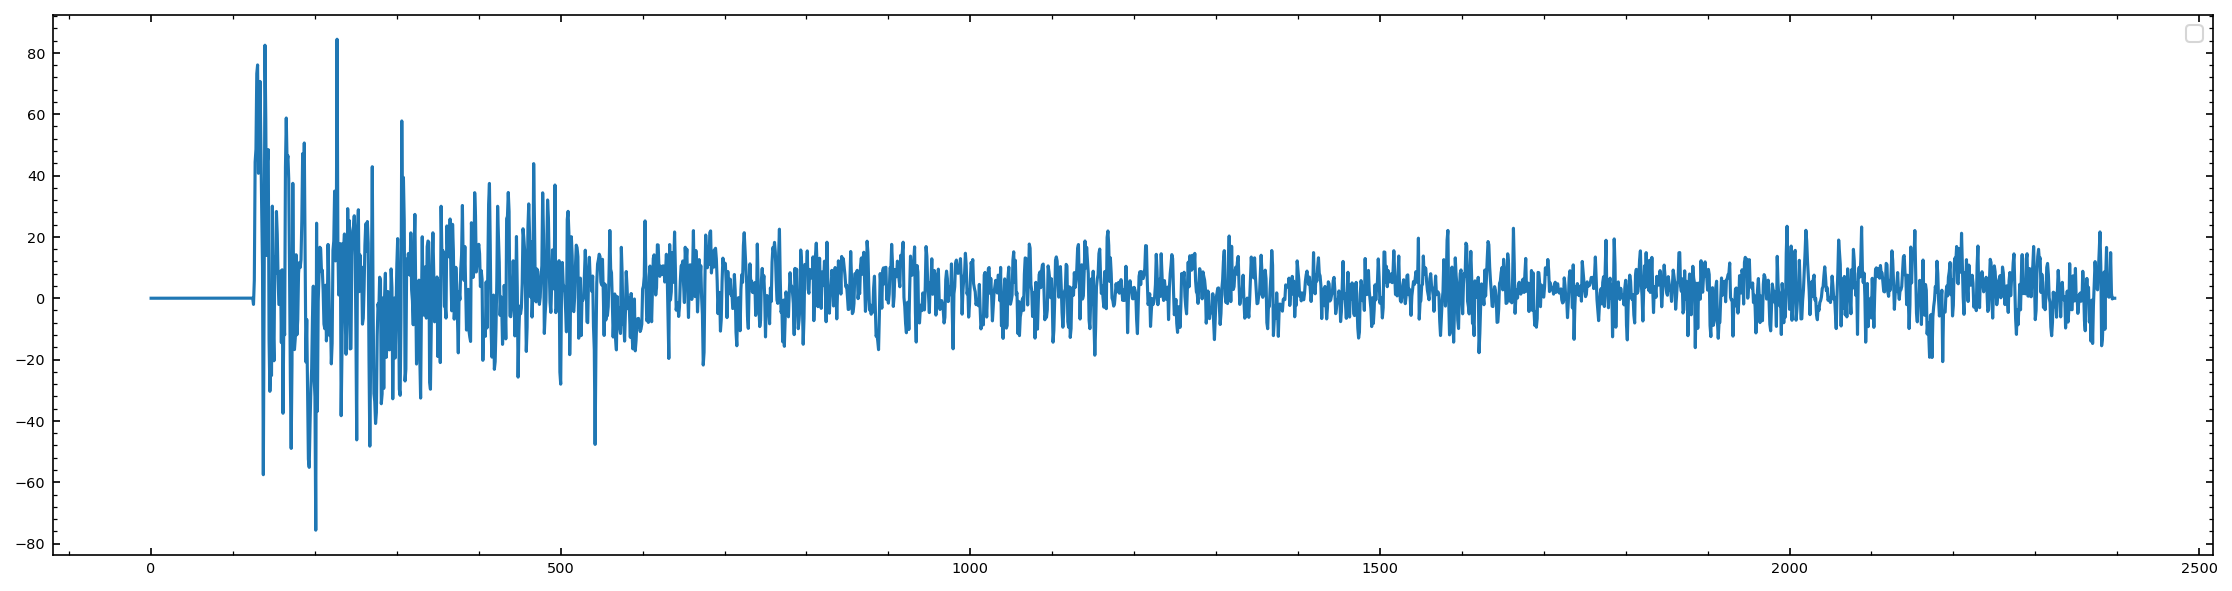

In [11]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=150, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(range(len(s.spectra)),s.spectra[:,0])


ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'', size=11)
ax1.set_ylabel(r'', size=11)

ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

In [12]:
# fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(6,4), dpi=150, tight_layout=True)
# gs1 = gridspec.GridSpec(1, 1)
# gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
# ax1 = plt.subplot(gs1[0])

# ax1.plot(s.x,s.y, '.', color='tab:blue', ms=1, alpha=.9)


# ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
# ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
# ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


# ax1.set_xlabel(r'$64 \times 0.58^{\prime \prime}$', size=11)
# ax1.set_ylabel(r'$24 \times 2.65^{\prime \prime}$', size=11)

# ax1.legend()

# # plt.savefig('./', format='pdf', bbox_inches='tight')

In [13]:
# plt.plot(s.spectra)

In [14]:
signal = np.median(s.spectra, 0)
# noise = np.sqrt(signal)
noise = np.full_like(signal,0.1)
target_sn = 350
# target_sn = 60

In [15]:
# noise[ noise<=0 ]

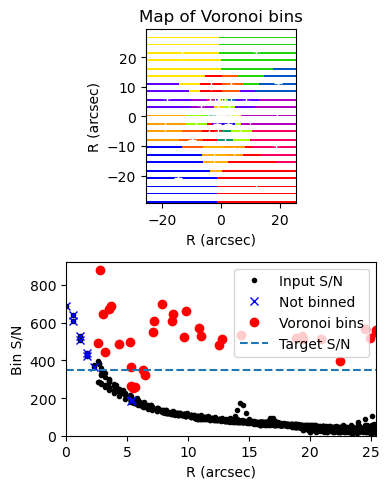

In [16]:
plt.figure(figsize=(4, 5))
bin_num = voronoi_2d_binning(s.x, s.y, signal, noise, target_sn, plot=1, quiet=1)[0]
plt.tight_layout()

## Setup stellar templates 

pPXF can be used with any set of SPS population templates. However, I am
currently providing (with permission) ready-to-use template files for four
SPS. One can just uncomment one of the four models below. The included files
are only a subset of the SPS that can be produced with the models, and one
should use the relevant software/website to produce different sets of SPS
templates if needed.

1. If you use the [fsps v3.2](https://github.com/cconroy20/fsps) SPS model
   templates, please also cite in your paper 
   [Conroy et al. (2009)](https://ui.adsabs.harvard.edu/abs/2009ApJ...699..486C) and
   [Conroy et al. (2010)](https://ui.adsabs.harvard.edu/abs/2010ApJ...712..833C).

2. If you use the [GALAXEV v2020](http://www.bruzual.org/bc03/) SPS model 
   templates, please also cite in your paper 
   [Bruzual & Charlot (2003)](https://ui.adsabs.harvard.edu/abs/2003MNRAS.344.1000B).

3. If you use the [E-MILES](http://miles.iac.es/) SPS model templates,
   please also cite  in your paper 
   [Vazdekis et al. (2016)](https://ui.adsabs.harvard.edu/abs/2016MNRAS.463.3409V).
   <font color="red">WARNING: The E-MILES models only include SPS with age > 63 Myr and
   are not recommended for highly star forming galaxies.</font>

4. If you use the [X-Shooter Spectral Library (XSL)](http://xsl.u-strasbg.fr/) 
   SPS model templates, please also cite in your paper 
   [Verro et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022A%26A...661A..50V). 
   <font color="red">WARNING: The XSL models only include SPS with age > 50 Myr and
   are not recommended for highly star forming galaxies.</font>

In [17]:
sps_name = 'emiles'
ppxf_dir = Path(lib.__file__).parent
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename

In [18]:
FWHM_gal = None   # set this to None to skip templates broadening
sps = lib.sps_lib(filename, s.velscale, FWHM_gal, norm_range=[4800, 5300])

In [19]:
s.velscale

10.823233432636641

In [20]:
s.velscale

10.823233432636641

In [21]:
npix, *reg_dim = sps.templates.shape
sps.templates = sps.templates.reshape(npix, -1)

In [22]:
sps.templates /= np.median(sps.templates) # Normalizes stellar templates by a scalar
regul_err = 0.01 # Desired regularization error

## Fit templates and stellar kinematics in Voronoi binned data

Create a mask for the main gas emission lines in the rest frame

In [23]:
vel_s = c * spectrum_z
vel_dis_s = 40 # Set the dis v = 40 km/s

In [24]:
lam_range_temp = np.exp(sps.ln_lam_temp[[0, -1]])
mask0 = util.determine_mask(s.ln_lam_gal, lam_range_temp, width=1000)

 Best Fit:       Vel     sigma
 comp.  0:       -97        11
chi2/DOF: 87.76; DOF: 1841; degree = 4; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 23; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/150
 Best Fit:       Vel     sigma
 comp.  0:       -99         8
chi2/DOF: 56.26; DOF: 1775; degree = 4; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/150
Weighted <lg_age> [yr]: 8.50
Weighted <[M/H]>: -1.30
Voronoi bin 1 / 45; SPS: emiles; $\sigma$=8 km/s; S/N=9.4
##############################################################################
 Best Fit:       Vel     sigma
 comp.  0:       -97        11
chi2/DOF: 75.43; DOF: 1841; degree = 4; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 20; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/150
 Best Fit:       Vel     sigma
 comp.  0:      -102        12
chi2/DOF: 49.74; DOF: 1768; degree = 4; mdegree = 0
method = 

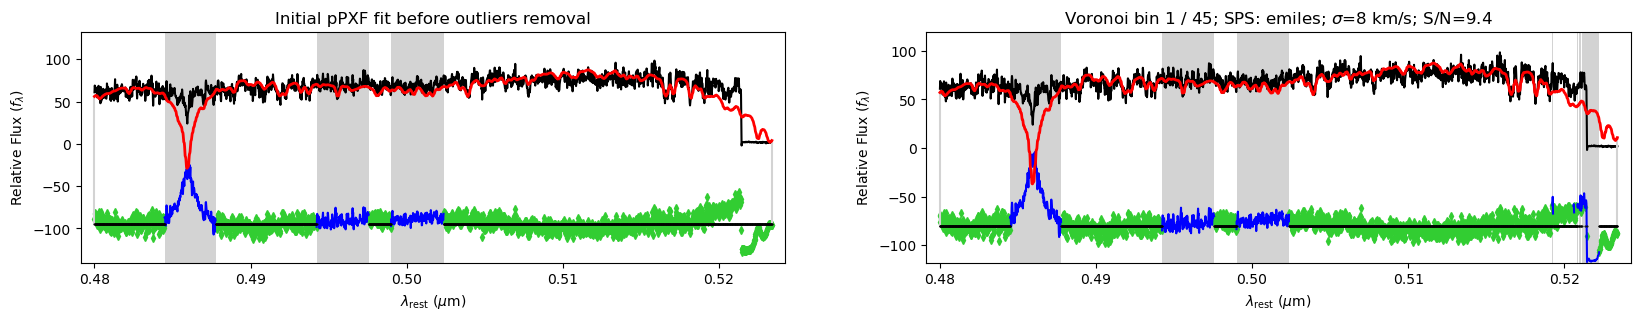

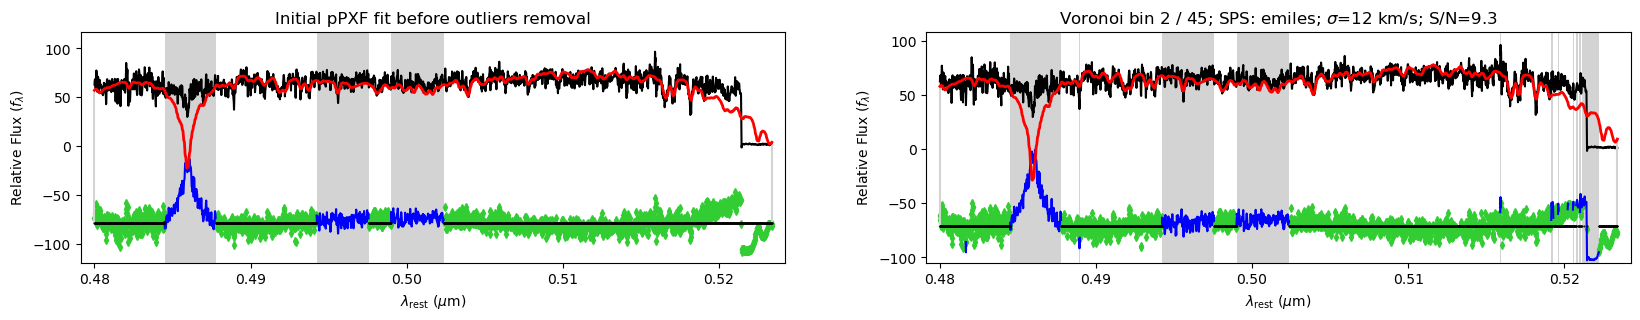

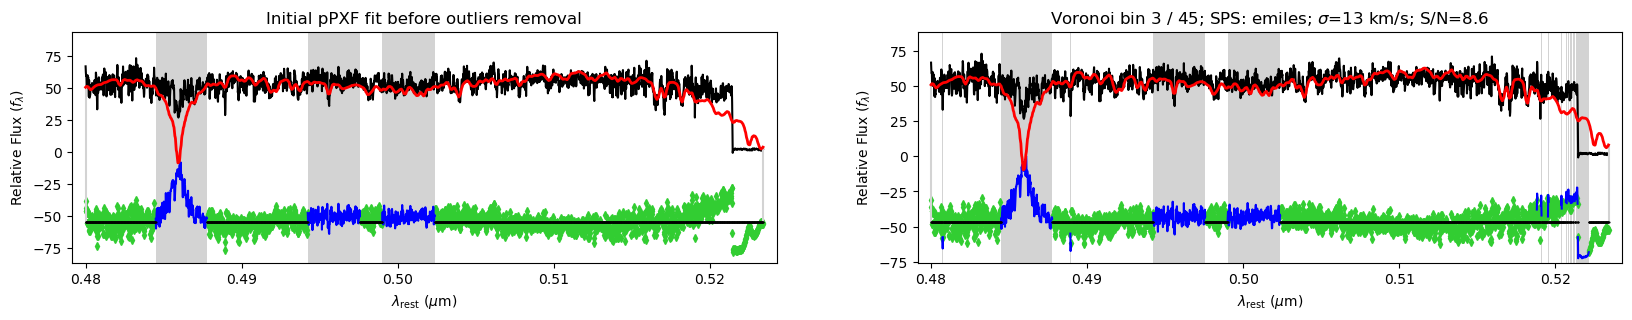

In [25]:
vel0 = 0                # Spectrum was de-redshifted. Initial guess is zero
start = [vel0, 200.]    # (km/s), starting guess for [V,sigma]

# start = [vel_s, vel_dis_s]

nbins = np.unique(bin_num).size
velbin, sigbin, lg_age_bin, metalbin, nspax = np.zeros((5, nbins))
optimal_templates = np.empty((npix, nbins))
lam_gal = np.exp(s.ln_lam_gal)

for j in range(nbins):
    plot = True if j < 3 else False  # Only plot the first few spectra
    w = bin_num == j
    galaxy = np.nanmean(s.spectra[:, w], 1)
    pp = ppxf_fit_and_clean(sps.templates, galaxy, s.velscale, start, mask0, lam_gal, sps.lam_temp, plot=plot, quiet=not plot)
    velbin[j], sigbin[j] = pp.sol
    optimal_templates[:, j] = pp.optimal_template
    light_weights = pp.weights.reshape(reg_dim)
    lg_age_bin[j], metalbin[j] = sps.mean_age_metal(light_weights, quiet=not plot)

    if plot:
        txt = f"Voronoi bin {j + 1} / {nbins}; SPS: {sps_name}; $\\sigma$={sigbin[j]:.0f} km/s; S/N={pp.sn:.1f}"
        print(txt + '\n' + '#'*78)
        plt.title(txt)

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_30564\1912370818.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])


ValueError: x and y must have same first dimension, but have shapes (2330,) and (2398,)

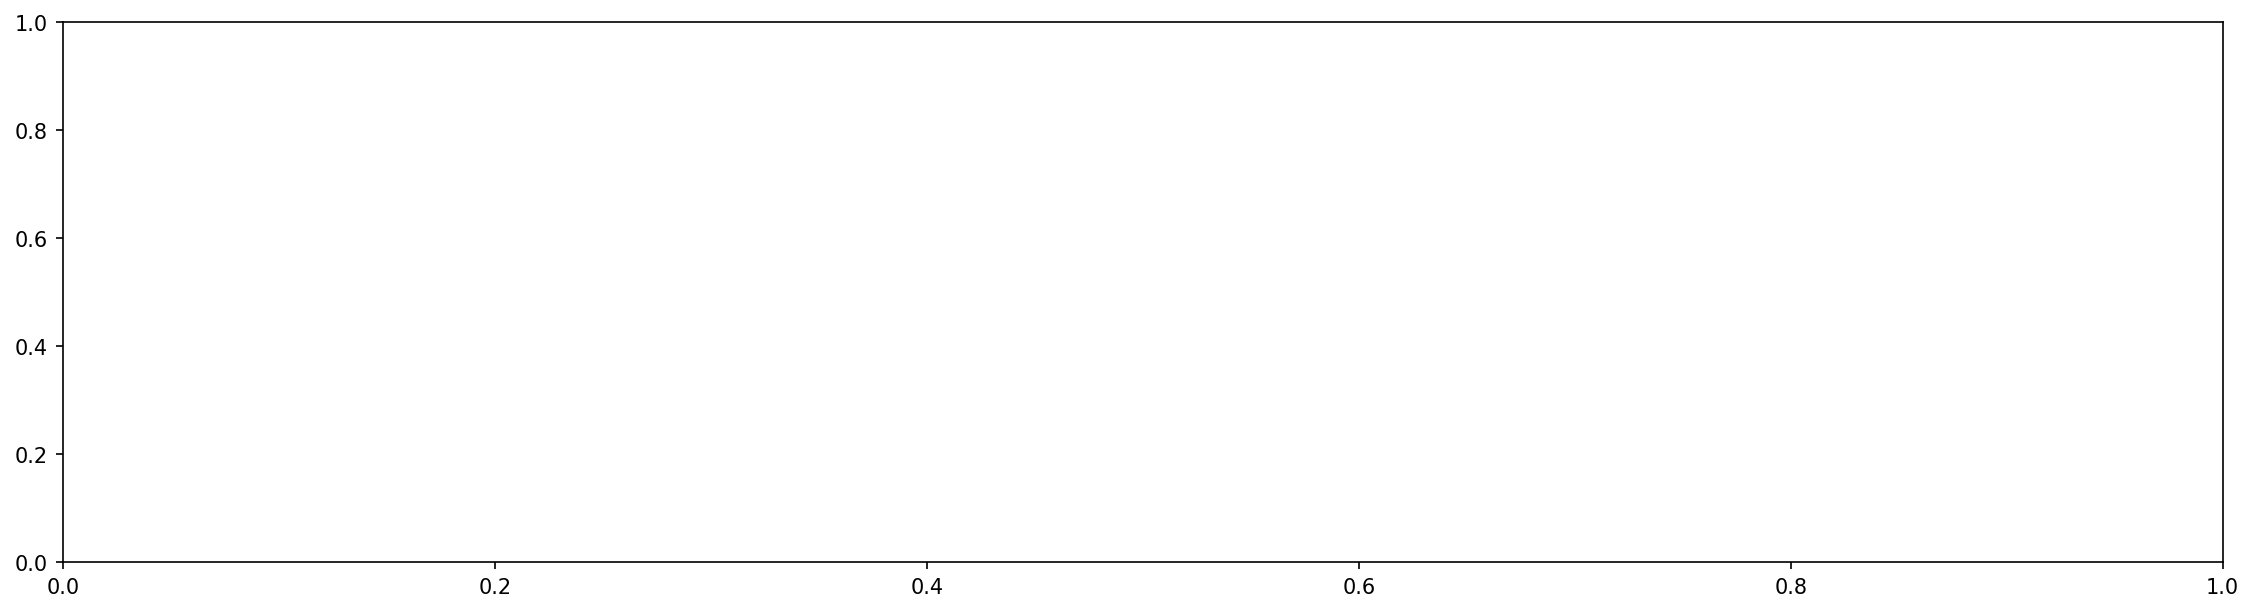

In [27]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=150, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(s.wave,galaxy)


ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'', size=11)
ax1.set_ylabel(r'', size=11)

ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

In [ ]:
len(s.wave)

In [ ]:
s.wave

In [ ]:
(5263-4821)/2330 * 340

In [83]:
# plt.subplots(1, 2, figsize=(10, 5))
# plt.subplots_adjust(wspace=0.5)

# plt.subplot(121)
# display_bins(s.x, s.y/(s.pixsize_y/s.pixsize_x), bin_num, velbin, colorbar=1, label='V (km/s)')
# plt.tricontour(s.x, s.y/(s.pixsize_y/s.pixsize_x), -2.5*np.log10(signal/np.max(signal).ravel()), levels=np.arange(20));  # 1 mag contours

# plt.subplot(122)
# display_bins(s.x, s.y/(s.pixsize_y/s.pixsize_x), bin_num, lg_age_bin, colorbar=1, cmap='inferno', label='lg Age (yr)')
# plt.tricontour(s.x, s.y/(s.pixsize_y/s.pixsize_x), -2.5*np.log10(signal/np.max(signal).ravel()), levels=np.arange(20));  # 1 mag contours